In [1]:
import pandas as pd
from music21 import converter, note, stream, chord
import itertools
import warnings
import random
import numpy as np
import ast
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
import ast
import matplotlib.pyplot as plt
from collections import Counter
import joblib

warnings.filterwarnings("ignore")

In [2]:
#import de la table
path = 'data\maestro-v3.0.0.csv'
df = pd.read_csv(path)

In [3]:
#On sélectionne les auteurs avec au moins une musique label en tant que train, test et val
df_i = df.groupby(['canonical_composer','split'])['midi_filename'].count().reset_index().sort_values(by='canonical_composer')
df_i = df_i.reset_index().groupby('canonical_composer')['index'].count().reset_index()
comp = df_i[df_i['index']==3]['canonical_composer'].to_list()
df = df[df['canonical_composer'].isin(comp)]

#Si on reduit l'étude à un ou plusieurs auteurs (par soucis de temps de calcul tout en conservant une similarité dans les styles)
df_i = df.groupby('canonical_composer')['midi_filename'].count().reset_index().sort_values(by='midi_filename')
comp = df_i['canonical_composer'].to_list()[0:3] #Sélection du nombre d'auteurs : les premiers ont moins de musiques et inversement
df = df[df['canonical_composer'].isin(comp)]

In [4]:
comp

['Franz Schubert / Franz Liszt', 'Johannes Brahms', 'Felix Mendelssohn']

In [5]:
df

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
125,Felix Mendelssohn,Etude in A Minor,validation,2008,2008/MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MI...,2008/MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MI...,76.044262
126,Felix Mendelssohn,"Fantasy in F-sharp Minor, Op. 28 (Complete)",test,2017,2017/MIDI-Unprocessed_059_PIANO059_MID--AUDIO-...,2017/MIDI-Unprocessed_059_PIANO059_MID--AUDIO-...,661.205093
127,Felix Mendelssohn,"Rondo Capriccioso in E Minor, Op. 14",validation,2013,2013/ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_06_...,2013/ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_06_...,362.836176
128,Felix Mendelssohn,"Rondo Capriccioso in E Minor, Op. 14",validation,2011,2011/MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1...,2011/MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1...,359.457440
129,Felix Mendelssohn,Variations Serieuses Op. 54,train,2017,2017/MIDI-Unprocessed_070_PIANO070_MID--AUDIO-...,2017/MIDI-Unprocessed_070_PIANO070_MID--AUDIO-...,724.481493
...,...,...,...,...,...,...,...
889,Johannes Brahms,"Variations on a Theme by Paganini, Op. 35 Book II",train,2015,2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-f...,2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-f...,630.978125
890,Johannes Brahms,"Variations on a Theme by Paganini, Op. 35 Book II",train,2015,2015/MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDI...,2015/MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDI...,636.198958
891,Johannes Brahms,"Variations on a Theme by Paganini, Op. 35, Boo...",train,2013,2013/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_07_...,2013/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_07_...,678.292591
892,Johannes Brahms,"Variations on a Theme by Paganini, Op. 35, Vol...",train,2004,2004/MIDI-Unprocessed_XP_04_R1_2004_01-02_ORIG...,2004/MIDI-Unprocessed_XP_04_R1_2004_01-02_ORIG...,1479.741361


In [8]:
df['duration'].median()

661.778740577

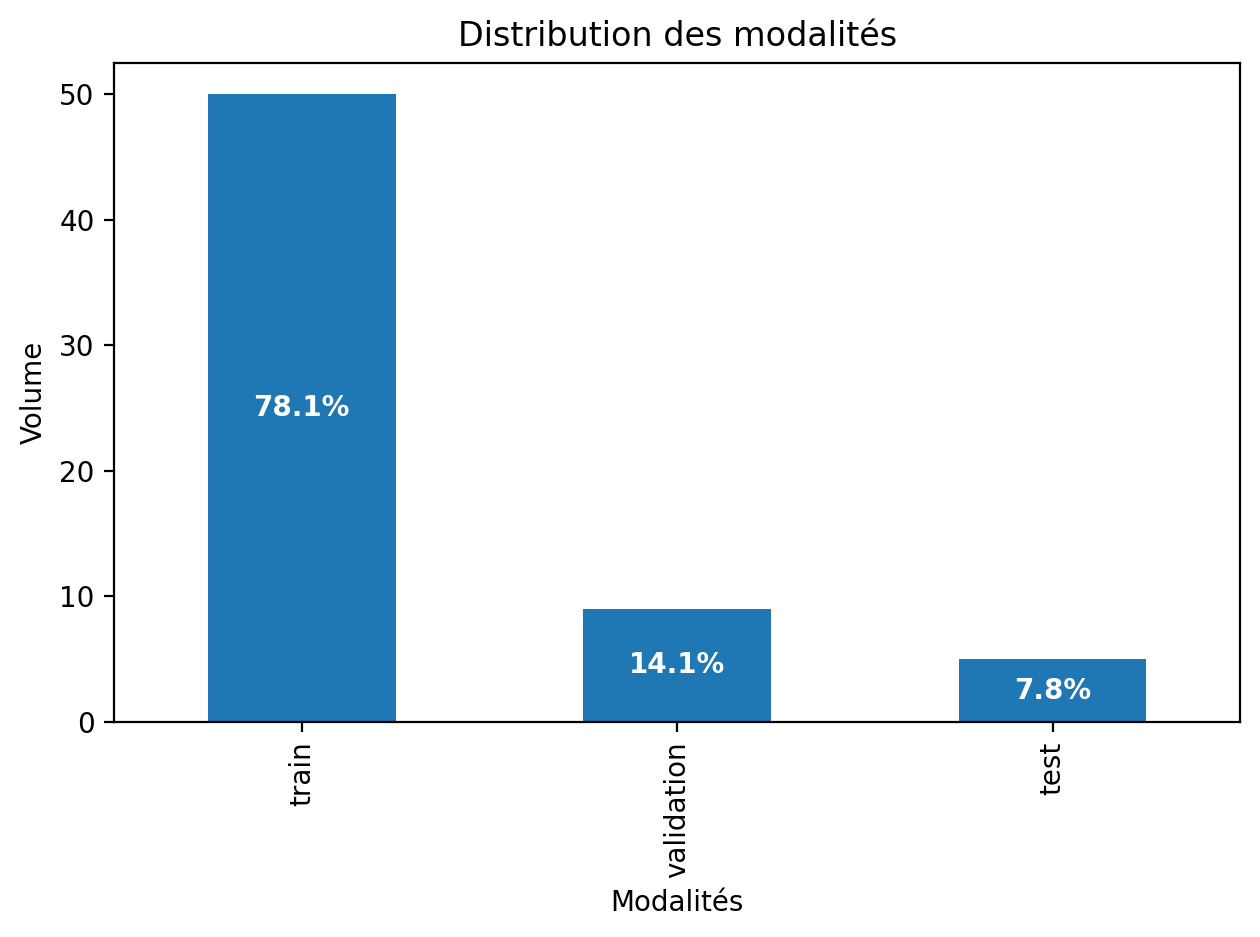

In [9]:
counts = df['split'].value_counts()
total = counts.sum()
percentages = counts / total * 100

# Tracer le graphique
ax = counts.plot(kind='bar')

# Afficher les % au centre des barres
for i, (count, percent) in enumerate(zip(counts, percentages)):
    ax.text(i, count / 2, f'{percent:.1f}%', ha='center', va='center', color='white', fontweight='bold')

# Ajouter titre et labels
plt.title("Distribution des modalités")
plt.xlabel("Modalités")
plt.ylabel("Volume")

plt.tight_layout()
plt.show()

In [12]:
def extraction_notes(file):
    '''
    Fonction pour extraires les notes d'un fichiers midi dans une liste
    avec les éléments int compris entre 0 et 127 
    Pour les accords on ne prend que la note la plus haute (la plus aigue)
    '''
    midi = converter.parse(file)
    L_notes = []
    for e in midi.recurse().notes:
        if e.isNote:
            N = e.pitch.midi
            L_notes.append(N)
        elif e.isChord:
            accords = [n.midi for n in e.pitches]
            N = max(accords)
            L_notes.append(N)
    if len(L_notes)<50:
        return 'null'
    else:
        return L_notes 
    
def ex_notes_tab(df,col_out):
    '''
    Création de la colonne contenant la liste des notes
    '''
    df['midi_file_data'] = 'data/'+df['midi_filename']
    df[col_out] = df['midi_file_data'].apply(extraction_notes)
    return df[df[col_out]!='null']

df_train = ex_notes_tab(df[df['split']=='train'],'notes')
df_val = ex_notes_tab(df[df['split']=='validation'],'notes')
df_test = ex_notes_tab(df[df['split']=='test'],'notes')

In [28]:
def extraction_notes(file):
    '''
    Fonction pour extraires les notes d'un fichiers midi dans une liste
    avec les éléments int compris entre 0 et 127 
    Pour les accords on ne prend que la note la plus haute (la plus aigue)
    '''
    midi = converter.parse(file)
    L_notes = []
    for e in midi.recurse().notes:
        if e.isNote:
            N = e.pitch.midi
            L_notes.append(N)
        elif e.isChord:
            accords = [n.midi for n in e.pitches]
            N = max(accords)
            L_notes.append(N)
    if len(L_notes)<50:
        return 'null'
    else:
        return L_notes 
    
def ex_notes_tab(df,col_out):
    '''
    Création de la colonne contenant la liste des notes
    '''
    df['midi_file_data'] = 'data/'+df['midi_filename']
    df[col_out] = df['midi_file_data'].apply(extraction_notes)
    return df[df[col_out]!='null']


def sequence_list(L):
    ''' création des séquences de 50 notes et output cette liste et de la note suivante (cible)'''
    sequence_length = 50

    input_sequences = []
    output_notes = []

    for i in range(len(L) - sequence_length):
        seq_in = L[i:i + sequence_length]  
        seq_out = L[i + sequence_length]  
        input_sequences.append(seq_in)
        output_notes.append(seq_out)

    return input_sequences,output_notes

def sequence(dff):
    ''' 
    Application du séquencage à toutes les musiques
    '''
    X,y = [],[]
    for k in dff['notes'].to_list():
        xtemp,ytemp = sequence_list(k)
        X.append(xtemp)
        y.append(ytemp)
    X=list(itertools.chain(*X))
    y=list(itertools.chain(*y))

    return pd.DataFrame({"X":X,"y":y})

def colonnes(df):
    ''' mise en forme : 1 temps = 1 colonne = 1 note '''
    df_expanded = df['X'].apply(pd.Series)
    df_expanded['y'] = df['y']
    return df_expanded

def preprocessing(df):
    ''' application de toutes les fonctions de preprocessing '''
    dftrain = colonnes(sequence(ex_notes_tab(df[df['split']=='train'],'notes')))
    dftest = colonnes(sequence(ex_notes_tab(df[df['split']=='test'],'notes')))
    dfval = colonnes(sequence(ex_notes_tab(df[df['split']=='validation'],'notes')))

    return dftrain,dftest,dfval

dftrain,dftest,dfval = preprocessing(df)

In [29]:
dftrain

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,y
0,65,69,64,62,74,68,67,70,69,65,...,59,64,62,68,63,67,58,62,69,59
1,69,64,62,74,68,67,70,69,65,67,...,64,62,68,63,67,58,62,69,59,62
2,64,62,74,68,67,70,69,65,67,69,...,62,68,63,67,58,62,69,59,62,60
3,62,74,68,67,70,69,65,67,69,73,...,68,63,67,58,62,69,59,62,60,70
4,74,68,67,70,69,65,67,69,73,74,...,63,67,58,62,69,59,62,60,70,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197397,94,88,53,96,83,90,91,95,96,93,...,86,81,79,88,57,85,45,91,93,84
197398,88,53,96,83,90,91,95,96,93,87,...,81,79,88,57,85,45,91,93,84,85
197399,53,96,83,90,91,95,96,93,87,93,...,79,88,57,85,45,91,93,84,85,91
197400,96,83,90,91,95,96,93,87,93,88,...,88,57,85,45,91,93,84,85,91,84


In [34]:
dftrain.shape[0]+dfval.shape[0]+dftest.shape[0]

245924

In [35]:
dftest.shape[0]

14389

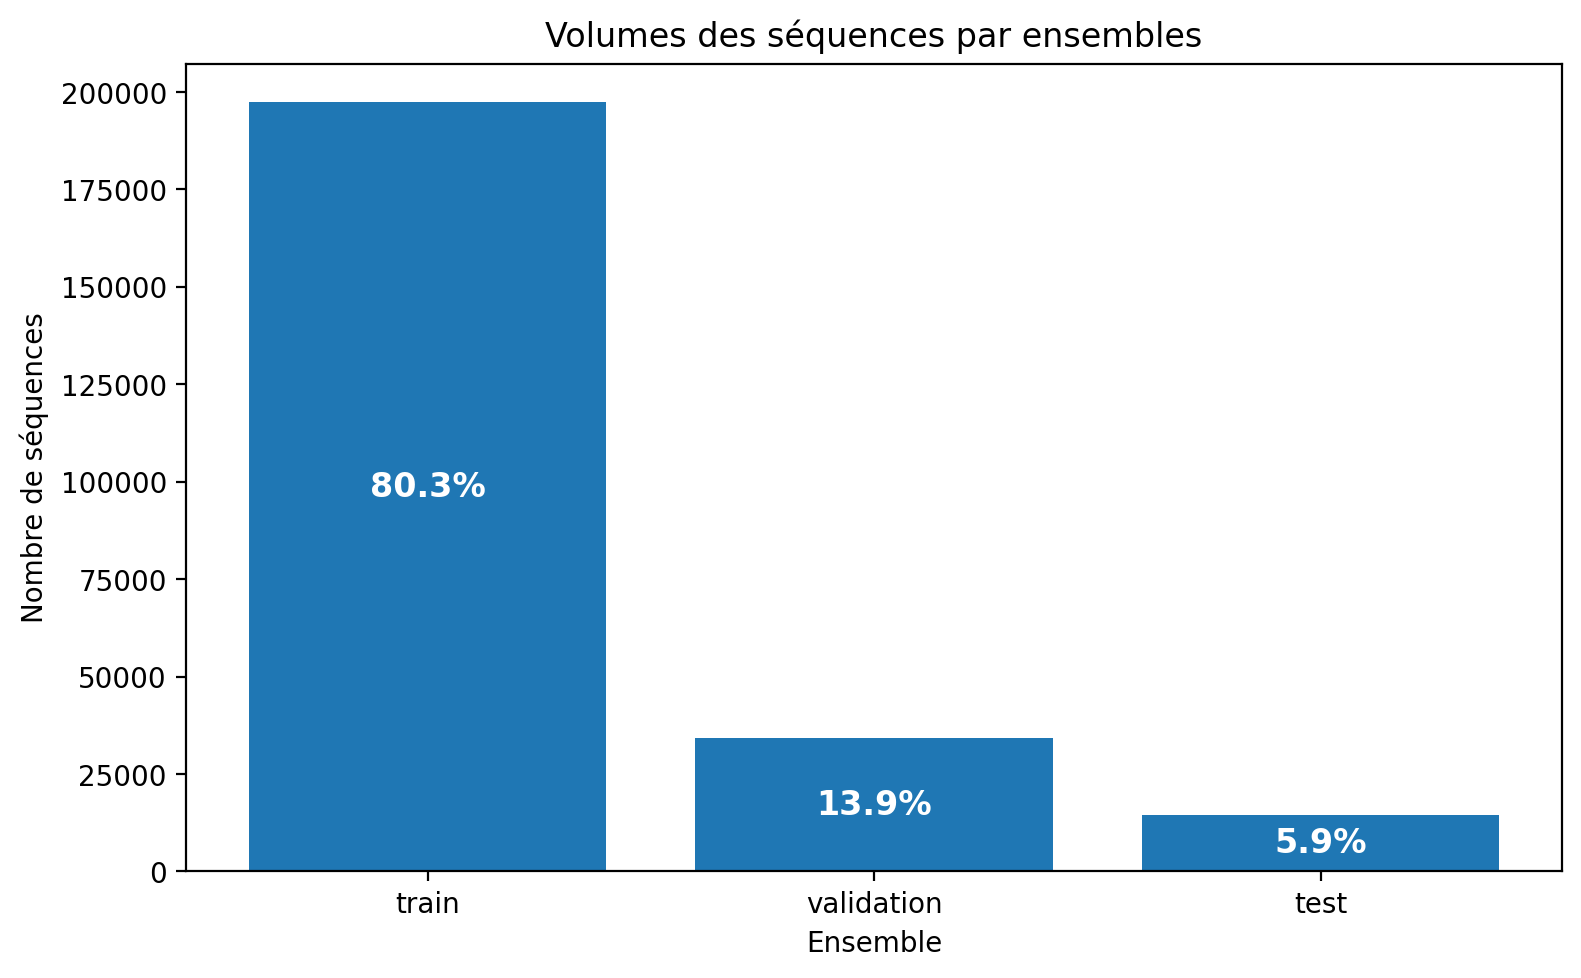

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que dftrain, dfval, dftest sont déjà définis
dfp = pd.DataFrame({
    "Modalités": ['train', 'validation', 'test'],
    "Volume": [dftrain.shape[0], dfval.shape[0], dftest.shape[0]]
})

# Calcul des pourcentages
total = dfp["Volume"].sum()
dfp["Pourcentage"] = dfp["Volume"] / total * 100

# Création du diagramme en barres
plt.figure(figsize=(8, 5))
bars = plt.bar(dfp["Modalités"], dfp["Volume"])

# Ajout des pourcentages au milieu des barres
for bar, pct in zip(bars, dfp["Pourcentage"]):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height() / 2
    plt.text(x, y, f"{pct:.1f}%", ha='center', va='center', color='white', fontsize=12, fontweight='bold')

plt.title("Volumes des séquences par ensembles")
plt.xlabel("Ensemble")
plt.ylabel("Nombre de séquences")

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

N = []
for k in df_train['notes'].to_list() + df_val['notes'].to_list() + df_test['notes'].to_list():
    N += k
compteur_notes = Counter(N)

# Trier les notes par nom (ex : C4, D#5, etc.)
notes_ordonnees = sorted(compteur_notes.items(), key=lambda x: x[0])

# Séparer noms et fréquences
noms_notes, frequences = zip(*notes_ordonnees)

# Créer une seule figure avec deux sous-graphes
plt.figure(figsize=(10, 10))

# Premier graphique : toutes les notes avec octaves
plt.subplot(2, 1, 1)
plt.bar(noms_notes, frequences)
plt.title("Fréquence des notes dans les fichiers séélectionnés")
plt.xlabel("Notes (entiers midi)")
plt.ylabel("Occurrences")
plt.xticks(rotation=45)

# Deuxième graphique : notes sans octave (classes de hauteur)
N2 = [n % 12 for n in N]
frequences = Counter(N2)

noms_notes_simple = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
valeurs = [frequences.get(i, 0) for i in range(12)]

plt.subplot(2, 1, 2)
plt.bar(noms_notes_simple, valeurs)
plt.xlabel("Notes (sans octave)")
plt.ylabel("Fréquence")
plt.title("Fréquence des notes indépendamment de l'octave")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


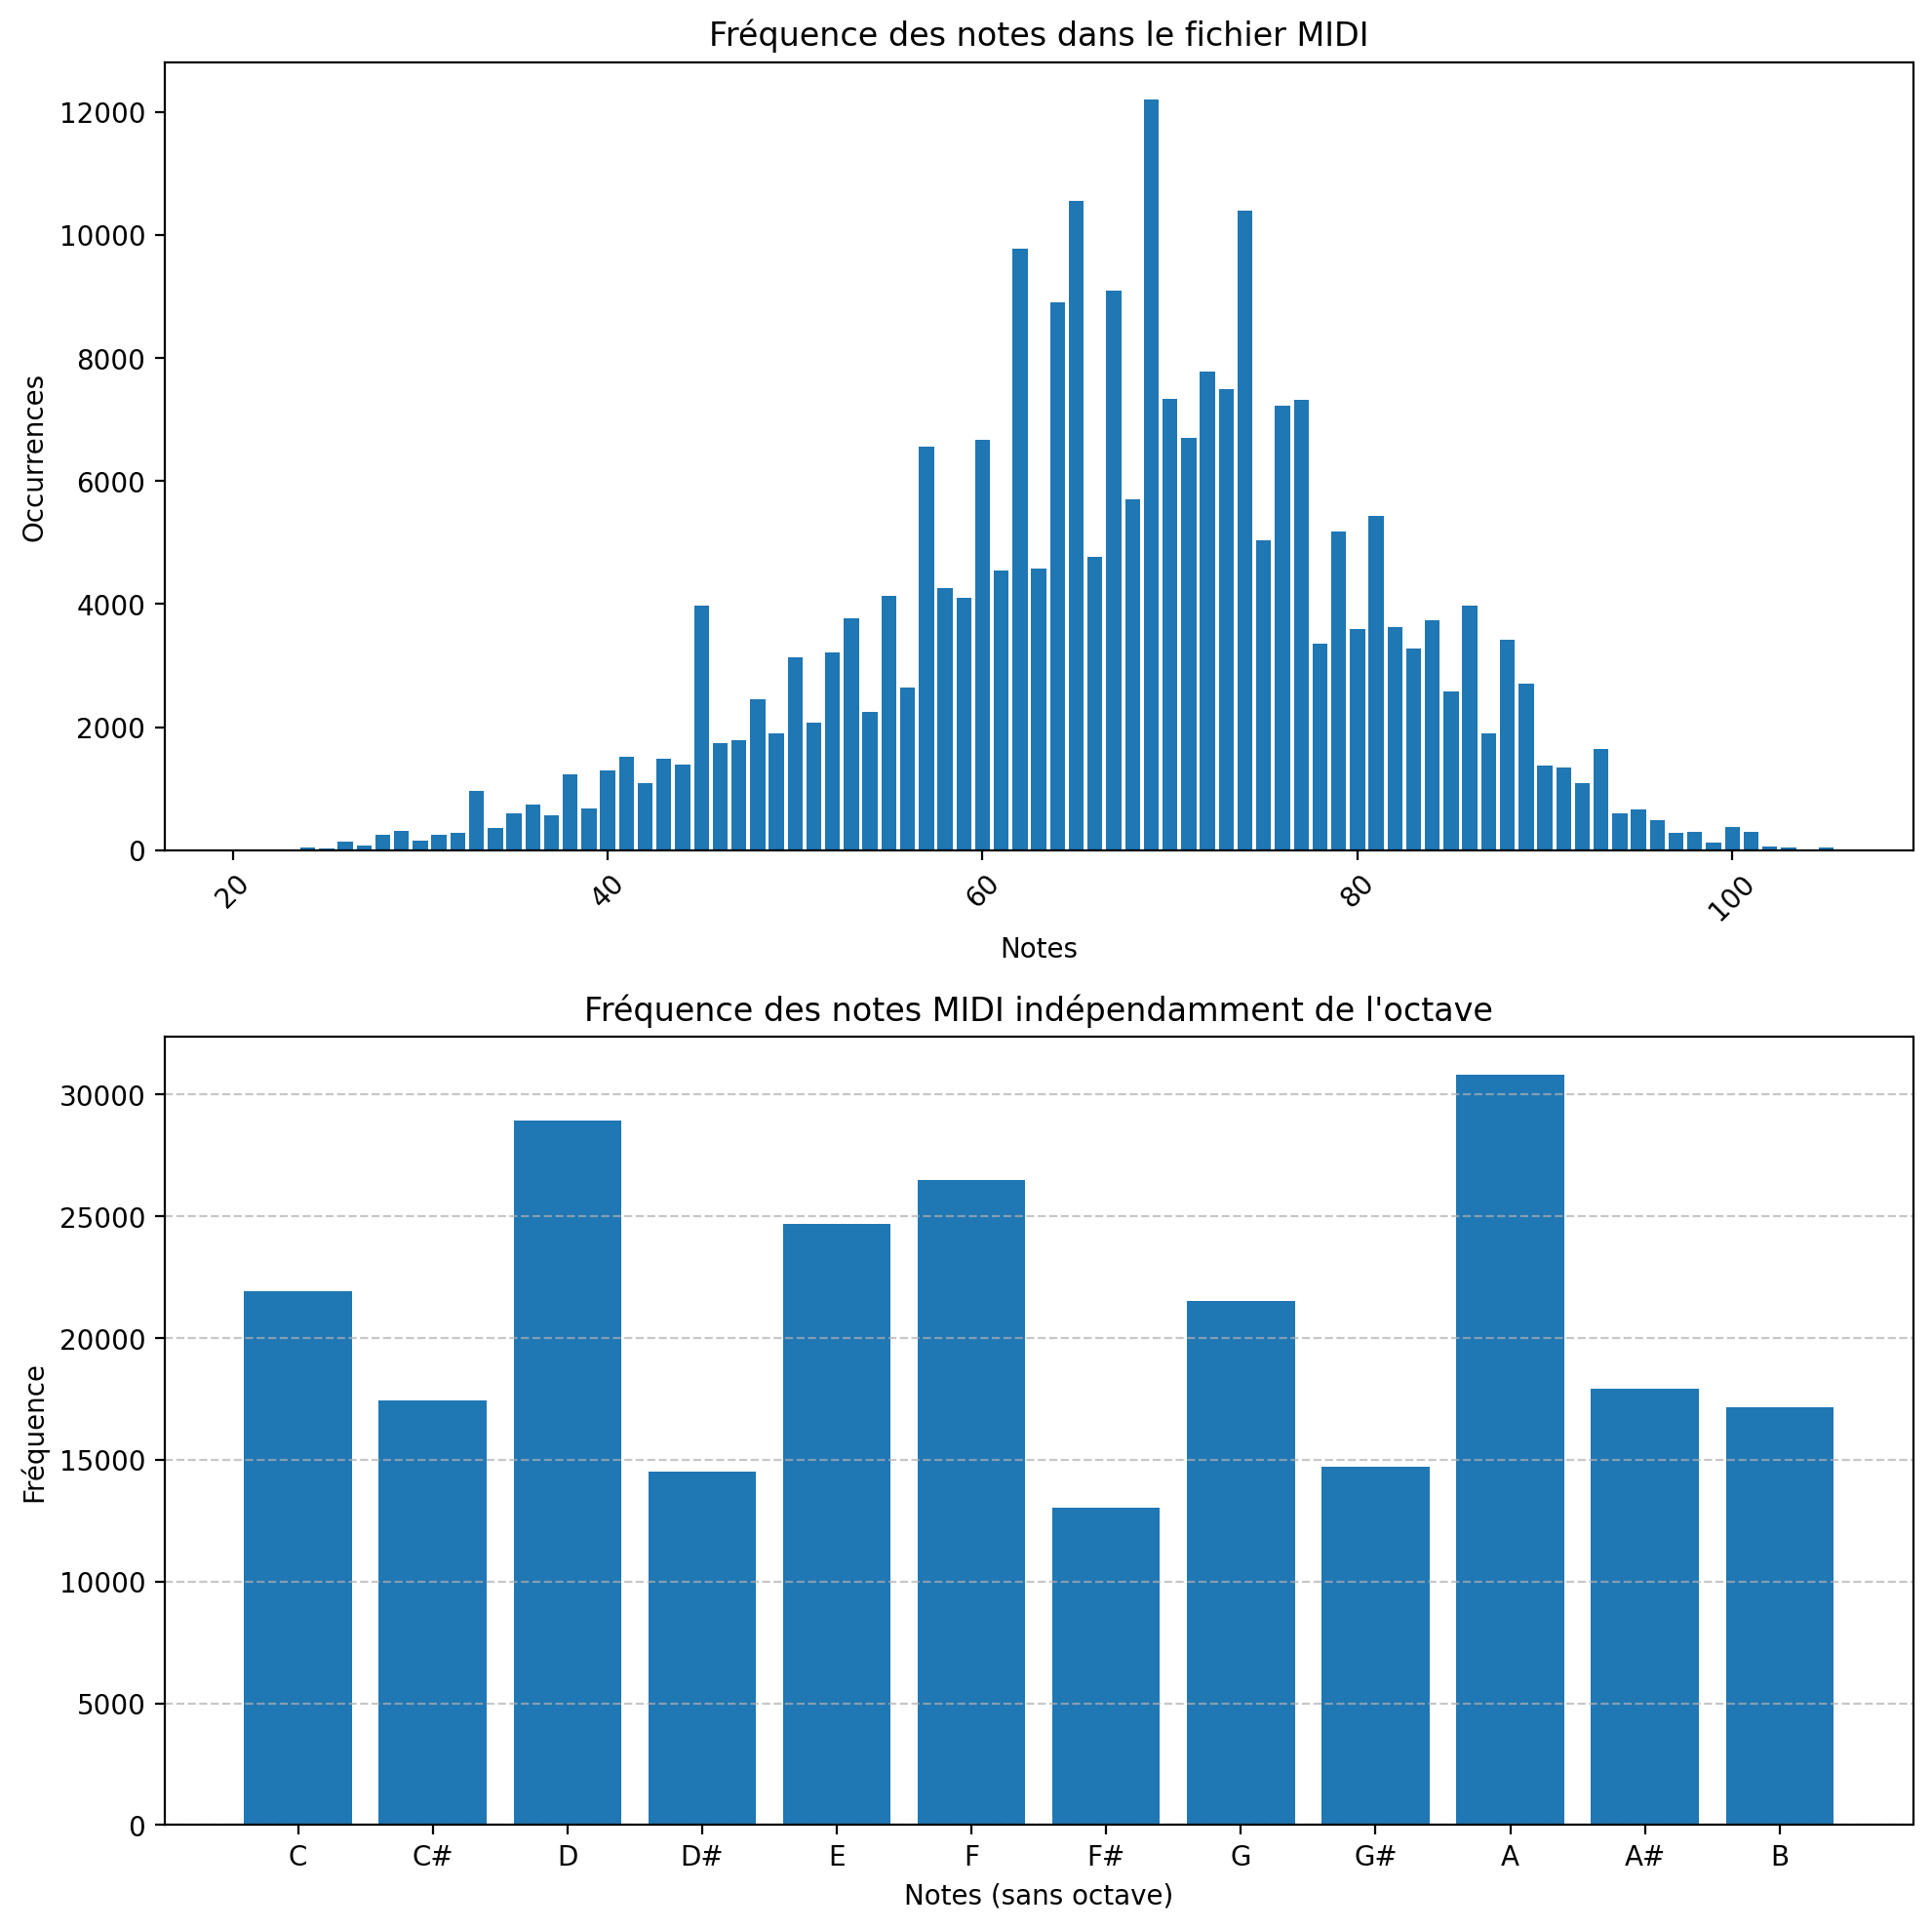

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

N = []
for k in df_train['notes'].to_list() + df_val['notes'].to_list() + df_test['notes'].to_list():
    N += k
compteur_notes = Counter(N)

# Trier les notes par nom (ex : C4, D#5, etc.)
notes_ordonnees = sorted(compteur_notes.items(), key=lambda x: x[0])

# Séparer noms et fréquences
noms_notes, frequences = zip(*notes_ordonnees)

# Créer une seule figure avec deux sous-graphes
plt.figure(figsize=(10, 10))

# Premier graphique : toutes les notes avec octaves
plt.subplot(2, 1, 1)
plt.bar(noms_notes, frequences)
plt.title("Fréquence des notes dans les fichiers séélectionnés")
plt.xlabel("Notes (entiers midi)")
plt.ylabel("Occurrences")
plt.xticks(rotation=45)

# Deuxième graphique : notes sans octave (classes de hauteur)
N2 = [n % 12 for n in N]
frequences = Counter(N2)

noms_notes_simple = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
valeurs = [frequences.get(i, 0) for i in range(12)]

plt.subplot(2, 1, 2)
plt.bar(noms_notes_simple, valeurs)
plt.xlabel("Notes (sans octave)")
plt.ylabel("Fréquence")
plt.title("Fréquence des notes indépendamment de l'octave")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [15]:
notes_ordonnees

[(nan, 64)]